### Importing Necessary Packages

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  
from nltk.stem.lancaster import LancasterStemmer 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SAIKAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### Loading Dataset

In [3]:
data = pd.read_csv('train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


### Exploratory Data Analysis

In [6]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [8]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=data.iloc[:,2:].sum()
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

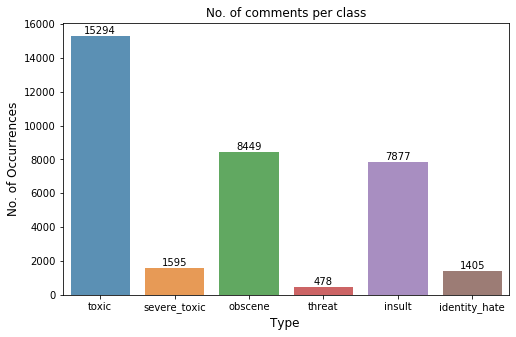

In [10]:
# Plot a chart with the following size
plt.figure(figsize=(8,5))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [11]:
#Total no. of rows in the dataset
num_rows = len(data)
print(num_rows)

159571


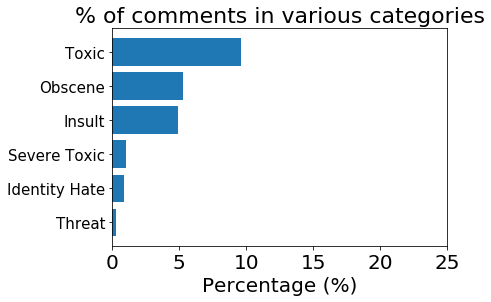

In [12]:
# Create a bar graph 
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100

# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()

### Preprocessing the Data

In [13]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

### Separating our dataset into 6 different datasets. Each dataset is comment + 1 category

In [14]:
data_tox = data.loc[:,['id','comment_text','toxic']]
data_sev = data.loc[:,['id','comment_text','severe_toxic']]
data_obs = data.loc[:,['id','comment_text','obscene']]
data_thr = data.loc[:,['id','comment_text','threat']]
data_ins = data.loc[:,['id','comment_text','insult']]
data_ide = data.loc[:,['id','comment_text','identity_hate']]

In [15]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


### Balancing the Datasets

Since the Dataset is highly imbalanced (with only 10% toxic data) we are taking a subset of the data where the proportion of the toxic comments are at least 20% (ideally 50%) in relation to non-toxic comments.

In [16]:
data_tox[data_tox['toxic'] == 1].count()

id              15294
comment_text    15294
toxic           15294
dtype: int64

In [17]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:15294,:]
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:15294,:]
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(30588, 3)

In [18]:
data_sev[data_sev['severe_toxic'] == 1].count()

id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [19]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

In [20]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [21]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:8449,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:8449,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(16898, 3)

In [22]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

The number of threat comments of 478 is too small, that's why we are taking the non-threat data as 80% to increase the size of the Dataset.

In [23]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [24]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [25]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:7877,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:7877,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(15754, 3)

In [26]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [27]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

### Import relevant packages for modelling

In [28]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


### Creating a simple function that takes in a dataset and allows user to choose dataset, toxicity label, vectorizer and number of ngrams

In [31]:
'''
df_done: data_tox_done, data_sev_done, ...
label: toxic, severe_toxic, ...
vectorizer values: TfidfVectorizer
gram_range values: (1,1) for unigram, (2,2) for bigram
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)
    print('knn done')

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)
    print('svm done')

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


### Let's create a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [32]:
import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_tox_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 75.0114119052887 seconds


,F1 Score(toxic)
Log Regression,0.887894
KNN,0.554768
BernoulliNB,0.772781
MultinomialNB,0.879544
SVM,0.892518
Random Forest,0.860996


In [33]:

t0 = time.time()

df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 2.2639129161834717 seconds


,F1 Score(severe_toxic)
Log Regression,0.927879
KNN,0.857416
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.934874


In [34]:

t0 = time.time()

df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 26.792502880096436 seconds


,F1 Score(obscene)
Log Regression,0.918019
KNN,0.303525
BernoulliNB,0.782343
MultinomialNB,0.901005
SVM,0.933121
Random Forest,0.920706


In [35]:

t0 = time.time()

df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 1.4990293979644775 seconds


,F1 Score(threat)
Log Regression,0.628821
KNN,0.720000
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.786765
Random Forest,0.795539


In [36]:

t0 = time.time()

df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 25.302454710006714 seconds


,F1 Score(insult)
Log Regression,0.907811
KNN,0.324476
BernoulliNB,0.780042
MultinomialNB,0.895084
SVM,0.907391
Random Forest,0.886805


In [37]:

t0 = time.time()

df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

lr done
knn done
bnb done
mnb done
svm done
rdf done
Time taken: 6.741040468215942 seconds


,F1 Score(identity_hate)
Log Regression,0.699029
KNN,0.230159
BernoulliNB,0.549206
MultinomialNB,0.485857
SVM,0.797516
Random Forest,0.768448


In [38]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all


,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.887894,0.927879,0.918019,0.907811,0.628821,0.699029
KNN,0.554768,0.857416,0.303525,0.324476,0.720000,0.230159
BernoulliNB,0.772781,0.803707,0.782343,0.780042,0.311828,0.549206
MultinomialNB,0.879544,0.936170,0.901005,0.895084,0.504762,0.485857
SVM,0.892518,0.926004,0.933121,0.907391,0.786765,0.797516
Random Forest,0.860996,0.934874,0.920706,0.886805,0.795539,0.768448


In [39]:
#Transpose the combined F1 dataframe to make it suitable for presentation on a graph
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.887894,0.554768,0.772781,0.879544,0.892518,0.860996
F1 Score(severe_toxic),0.927879,0.857416,0.803707,0.936170,0.926004,0.934874
F1 Score(obscene),0.918019,0.303525,0.782343,0.901005,0.933121,0.920706
F1 Score(insult),0.907811,0.324476,0.780042,0.895084,0.907391,0.886805
F1 Score(threat),0.628821,0.720000,0.311828,0.504762,0.786765,0.795539
F1 Score(identity_hate),0.699029,0.230159,0.549206,0.485857,0.797516,0.768448


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

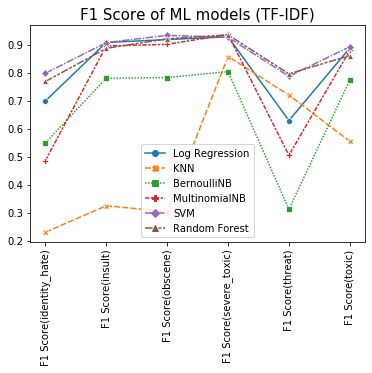

In [44]:
sns.lineplot(data=f1_all_trp, size=[20,20], markers=True)
plt.xticks(rotation='90', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=15)

### Pickling trained RandomForest models for all categories.

I chose Random Forest instead of LinearSVC although the latter performs well, as RDF has predict_proba function and LinearSVC does not. I wanted to output the probability score for each comment as well.

In [45]:
import pickle
def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    # Initiate a Tfidf vectorizer
    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    # Convert the X data into a document term matrix dataframe
    X_vect = tfv.fit_transform(X)  
    
    # saves the column labels (ie. the vocabulary)
    # wb means Writing to the file in Binary mode, written in byte objects
    with open(r"{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(tfv, f)   
        
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_vect, y)

    # Create a new pickle file based on random forest
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(randomforest, f)

In [46]:
#Create a loop to create pickle files all at one shot
datalist = [data_tox_done, data_sev_done, data_obs_done, data_ins_done, data_thr_done, data_ide_done]
label = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']

for i,j in zip(datalist,label):
    pickle_model(i, j)